#Introduction to Keras and TensorFlow

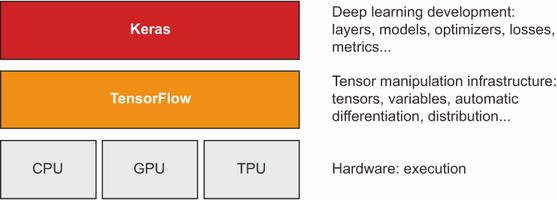

#Getting started with TensorFlow 

Training neural networks revolves around several concepts: 
1. The manipulation of tensors, the infrastructure that underlies all modern machine learning. This is translated into the TensorFlow APIs: 

- Tensors, including special tensors that store the state of the network (variables) 
- Tensor operations such as sum, relu, matmul 
- Backpropagation, a way of calculating the gradient of mathematical expressions (used TensorFlow through the GradientTape object) 

2. High-level deep learning concepts. This is translated into the Keras APIs: 
- Layers, which are combined into a model 
- Loss Function, which defines the feedback signal used for learning 
- Optimizer, which determines how fitting/learning is done to the data. 
- Metrics to assess model performance, such as accuracy 
- A training loop that performs mini-batch stochastic gradient descent 

#Constant and variable tensors 

Tensors are the basic data structure of TensorFlow and Keras. They must be created with a content and cannot be assigned a value. When it is necessary to change the state of a variable we will need the type tf.Variable, which must be created with an initial value as well. 

All-ones or all-zeros tensors

In [3]:
import tensorflow as tf
x = tf.ones(shape=(2, 1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


In [4]:
x = tf.zeros(shape=(2, 1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


#Random tensors

In [5]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[-1.8287381]
 [ 1.2501597]
 [-1.016692 ]], shape=(3, 1), dtype=float32)


In [6]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.9109868 ]
 [0.00707662]
 [0.5805929 ]], shape=(3, 1), dtype=float32)


NumPy arrays are assignable but tensors are not

In [7]:
import numpy as np
x = np.ones(shape=(2, 2))
x[0, 0] = 0.

In [8]:
try:
  x = tf.ones(shape=(2, 2))
  x[0, 0] = 0.
except Exception as e:
  print(e)

'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment


Create a TensorFlow variable

In [9]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 1.4983504 ],
       [-0.40454793],
       [ 0.18749124]], dtype=float32)>


Assign a value to a TensorFlow variable

In [10]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

Assign a value to a subset of a TensorFlow variable

In [11]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

The sum with `assign_add`

In [12]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

Mathematical Operations with Tensors

Basic operations

In [13]:
a = tf.ones((2, 2))
b = tf.square(a)
c = tf.sqrt(a)
d = b + c
e = tf.matmul(a, b)
e *= d

Gradient Tape API

How to use GradientTape

Simply open a scope of GradientTape, apply some calculation to one or more input tensors, and retrieve the gradient of the result with respect to the inputs.

$f(x)=x^2$

$
\frac{\partial f}{\partial x} = 2x
$


In [14]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
   result = tf.square(input_var) 
gradient = tape.gradient(result, input_var)
# the function would be f(x)=x^2; f'(x)=2x, being x = 3 f'(x)=6
print(input_var)
print(gradient)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>
tf.Tensor(6.0, shape=(), dtype=float32)


#GradientTape with constant tensors as input

So far, we've only seen the case where the input tensors in `tape.gradient()` were TensorFlow variables. In reality it is possible for these inputs to be any arbitrary tensor. However, only trainable variables are tracked by default. With a constant tensor, you have to manually mark it as being tracked by calling `tape.watch()` on it. This is done for reasons of computational efficiency.

In [15]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
   tape.watch(input_const)
   result = tf.square(input_const)
gradient = tape.gradient(result, input_const)
print(result)
print(gradient)

tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


A complete linear classifier in TensorFlow


#Generation of the data set

In [16]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

In [17]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

In [18]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

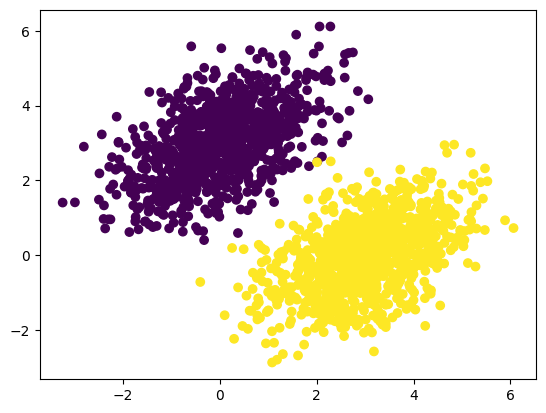

In [19]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

#Creating the linear model variables

We initialize `W` to random values ​​and `b` to zero.

In [20]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

Forward propagation

In [21]:
def model(inputs):
    return tf.matmul(inputs, W) + b

#Root mean square error (MSE) loss function

- `persample_loss` is a tensor with the same shape as targets and predictions and will store the loss corresponding to each pattern.

- We return the mean contribution to the batch error. `reduce_mean` by default reduces all dimensions to 1, but could be used to calculate tensor axis means.

In [22]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

#The training step

Remember that `GradientTape` allows us to derive with respect to lists of parameters. In this case, it returns the partial gradient with respect to each parameter in the list.

In [24]:
learning_rate = 0.1

def training_step(inputs, targets, loss=square_loss):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    # We update the weights by subtracting the gradient (opposite direction)
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

#Learning loop with the complete set (batch training)

For simplicity, we'll do batch training instead of mini-batch training: we'll run each training step (gradient calculation and weight update) for all the data, instead of iterating over the data in small batches.

This means that each training step will take much longer to run but each gradient update will be much more effective in reducing the loss function by including all the training data. This means that fewer training steps will be required and the learning rate should be higher than when using small batches (learning_rate = 0.1).

❓❓❓ EXERCISE

- Try using different learning rates in this example and see the result
- Does it make sense for the learning rate to be greater than 1?
- Try programming another loss function: the RMSE.
- How would you include a regularization term in the loss function?
❓❓❓

✅

In [28]:
learning_rate = 0.05

It doesn't make sense for the learning rate to be greater than 1, as this would cause the optimization process to diverge, and the loss would increase instead of decreasing.

This is another loss - RMSE

In [29]:
def rmse_loss(targets, predictions):
    return tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

In [30]:
def square_loss_with_l2(targets, predictions, l2_lambda=0.01):
    loss = tf.reduce_mean(tf.square(targets - predictions))
    regularizer = tf.reduce_sum(tf.square(W)) + tf.reduce_sum(tf.square(b))
    loss += l2_lambda * regularizer
    return loss

In [31]:
for step in range(40):
    loss = training_step(inputs, targets, square_loss_with_l2)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 0.3359
Loss at step 1: 0.1405
Loss at step 2: 0.0928
Loss at step 3: 0.0796
Loss at step 4: 0.0747
Loss at step 5: 0.0719
Loss at step 6: 0.0696
Loss at step 7: 0.0676
Loss at step 8: 0.0658
Loss at step 9: 0.0640
Loss at step 10: 0.0622
Loss at step 11: 0.0606
Loss at step 12: 0.0590
Loss at step 13: 0.0575
Loss at step 14: 0.0561
Loss at step 15: 0.0547
Loss at step 16: 0.0534
Loss at step 17: 0.0521
Loss at step 18: 0.0509
Loss at step 19: 0.0498
Loss at step 20: 0.0487
Loss at step 21: 0.0477
Loss at step 22: 0.0466
Loss at step 23: 0.0457
Loss at step 24: 0.0448
Loss at step 25: 0.0439
Loss at step 26: 0.0431
Loss at step 27: 0.0422
Loss at step 28: 0.0415
Loss at step 29: 0.0407
Loss at step 30: 0.0400
Loss at step 31: 0.0394
Loss at step 32: 0.0387
Loss at step 33: 0.0381
Loss at step 34: 0.0375
Loss at step 35: 0.0370
Loss at step 36: 0.0364
Loss at step 37: 0.0359
Loss at step 38: 0.0354
Loss at step 39: 0.0350


As we see the loss function more or less stabilizes.

Now we are going to predict the class of the patterns. In this binary classification example the decision threshold between the classes is `0.5` where class "1" is assigned for values ​​greater than the threshold.

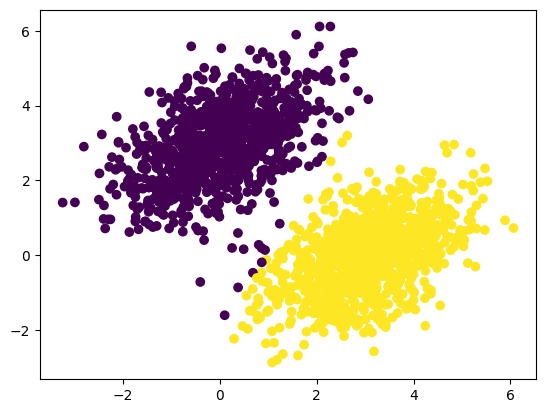

In [32]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

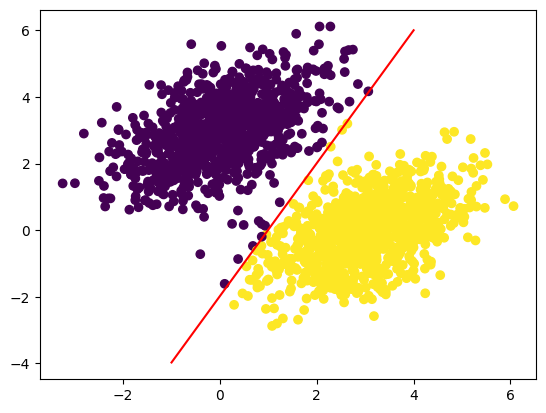

In [33]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

#Anatomy of a neural network to understand Keras concepts
Layers


The fundamental data structure in neural networks is the layer. A layer is a data processing module that takes one or more tensors as input and outputs one or more tensors. Some layers are stateless, but most often layers have a state: the layer weights, one or more tensors learned with gradient descent, which together store knowledge of the network.

Depending on the type of data we work with, there will be more appropriate types of layers to work with.

- Simple vector data, also called tabular ("spreadsheet"), stored in rank 2 tensors (sample, features), is usually processed by densely connected layers, also called fully connected layers (the Dense class in Keras). Data with temporal or sequence arrangement, rank 3 tensors (samples, time steps, features), are typically processed by recursive layers, such as an LSTM layer, or 1D convolution (Conv1D) layers. Image data, stored in rank 4 tensors, is typically processed by 2D convolution layers (Conv2D).


The Layer class in Keras


Almost everything in Keras revolves around an object of type Layer, which encapsulates a state of the weights and a calculation on the network (forward pass). The weights are defined in build() and the processing in call().

A Dense layer implemented as a subclass of `Layer`

In [50]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

This layer we've created can be instantiated and used as a function:

In [35]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


In [36]:
my_dense = SimpleDense(units=512, activation=tf.nn.tanh)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 512)


#Automatic layer shape deduction - building layers on the fly



In Keras in general we only need to specify the shape of the output tensors of the layer, since the layers that are added to the model are built dynamically to adapt each layer to the shape of the input layer (the output of the previous layer). .

The next layer can only connect to a layer that expects 32-dimensional vectors as input.

In [37]:
from tensorflow.keras import layers
layer = layers.Dense(32, activation="relu")

In Keras, the build of the layer is not implemented at all in the `__build__()` constructor waiting to know what the shape of the input from the previous layer will be.

In [38]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

In the network example we made from scratch we needed to perfectly specify the input and output dimensions of the layer sequence:



```
model = NaiveSequential([
    NaiveDense(input_size=784, output_size=32, activation="relu"),
    NaiveDense(input_size=32, output_size=64, activation="relu"),
    NaiveDense(input_size=64, output_size=32, activation="relu"),
    NaiveDense(input_size=32, output_size=10, activation="softmax")
])
```


In Keras, the following is enough:

In [39]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])

#From layers to models
A deep learning model consists of a layer graph, class Model in Keras. So far we have only seen the Sequential model, which is a subclass of Model but there are many other more advanced network topologies (Transformers, Residual...)

#The "compile" step to set up the learn process
Here we are going to configure:

1. Loss function (or objective function).
2. The optimizer.
3. Evaluation metrics on the trainset and optionally validation.
There are two alternatives to specify:

In [40]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])

In [41]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

#The importance of the loss function ❗❗❗❗
Choosing the right loss function for the right problem is extremely important: the network will take any shortcut it can to minimize loss, so if the goal is not fully correlated to the task at hand, the network will end up doing things that we probably don't want to.

Examples:

- Emotion detector?
- Maximize the average welfare of human beings?


#The fit() method
Calling fit() with NumPy data

In [42]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

Epoch 1/5
16/16 [==============================] - 0s 2ms/step - loss: 19.2232 - binary_accuracy: 0.5115
Epoch 2/5
16/16 [==============================] - 0s 2ms/step - loss: 18.5251 - binary_accuracy: 0.5120
Epoch 3/5
16/16 [==============================] - 0s 2ms/step - loss: 17.9309 - binary_accuracy: 0.5120
Epoch 4/5
16/16 [==============================] - 0s 2ms/step - loss: 17.3566 - binary_accuracy: 0.5120
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 16.7936 - binary_accuracy: 0.5120


In [43]:
history.history

{'loss': [19.22315216064453,
  18.52507781982422,
  17.930889129638672,
  17.356563568115234,
  16.793560028076172],
 'binary_accuracy': [0.5115000009536743,
  0.5120000243186951,
  0.5120000243186951,
  0.5120000243186951,
  0.5120000243186951]}

Loss monitoring and validation data metrics


validation_data parameter

In [44]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5
88/88 [==============================] - 1s 5ms/step - loss: 0.1584 - binary_accuracy: 0.9450 - val_loss: 0.0878 - val_binary_accuracy: 0.9950
Epoch 2/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0711 - binary_accuracy: 0.9521 - val_loss: 0.2104 - val_binary_accuracy: 0.8033
Epoch 3/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0670 - binary_accuracy: 0.9571 - val_loss: 0.1553 - val_binary_accuracy: 0.9100
Epoch 4/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0763 - binary_accuracy: 0.9507 - val_loss: 0.0451 - val_binary_accuracy: 0.9900
Epoch 5/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0706 - binary_accuracy: 0.9643 - val_loss: 0.1687 - val_binary_accuracy: 0.8283


#How to use the trained model
The model can be called as a function, but this would evaluate the entire test database directly instead of in batches.

`predictions = model(new_inputs)`
Usually it will be more appropriate to use the `predict` function

In [45]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

5/5 [==============================] - 0s 2ms/step
[[ 0.24935102]
 [ 0.24866468]
 [-0.57361794]
 [ 0.39618862]
 [ 0.6184122 ]
 [ 0.64507353]
 [ 0.5000814 ]
 [-0.42026937]
 [-0.4926597 ]
 [ 0.34310925]]


❓❓❓ EXERCISE

- Try using the previous 4-layer model with the MNIST database
It will not be enough to copy and paste. Pay attention to: input variables, adequate loss function, neurons per layer... You will have to calculate the average precision in test.
- Try viewing the model fit history
❓❓❓

✅


Load MNIST...

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data to the range [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Convert the labels to one-hot encoded vectors
y_train = tf.one_hot(y_train, depth=10)
y_test = tf.one_hot(y_test, depth=10)

# Reshape the input data to 2D arrays
x_train = x_train.reshape((len(x_train), -1))
x_test = x_test.reshape((len(x_test), -1))

11490434/11490434 [==============================] - 0s 0us/step


Define `SimpleDense`

In [53]:
class SimpleDense(keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(SimpleDense, self).__init__()
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)

    def call(self, inputs):
        outputs = tf.matmul(inputs, self.w) + self.b
        if self.activation is not None:
            outputs = self.activation(outputs)
        return outputs

In [54]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/10
1500/1500 [==============================] - 6s 3ms/step - loss: 0.5544 - accuracy: 0.8284 - val_loss: 0.3129 - val_accuracy: 0.9065
Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2703 - accuracy: 0.9201 - val_loss: 0.2228 - val_accuracy: 0.9329
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2015 - accuracy: 0.9403 - val_loss: 0.1833 - val_accuracy: 0.9445
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1599 - accuracy: 0.9520 - val_loss: 0.1764 - val_accuracy: 0.9444
Epoch 5/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.1322 - accuracy: 0.9597 - val_loss: 0.1537 - val_accuracy: 0.9529
Epoch 6/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.1132 - accuracy: 0.9659 - val_loss: 0.1549 - val_accuracy: 0.9541
Epoch 7/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0984 - accuracy: 0.9691 - val_loss: 0.1375 - val_accuracy:

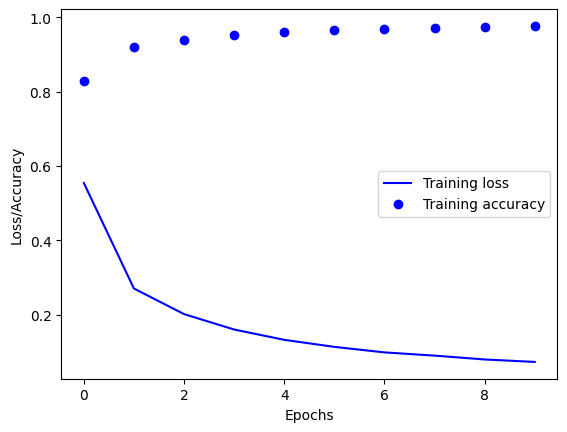

In [56]:
# You can use this code to view the training history
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
acc_values = history_dict["accuracy"]
plt.plot(loss_values, "b-", label="Training loss")
plt.plot(acc_values, "bo", label="Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()

#Summary
- TensorFlow is a framework that can run on CPU, GPU, and TPU.
- TensorFlow can calculate the gradient of any differentiable expression.
- Keras is an API for making deep learning models with TF.
- TF Key Objects: Tensors, Variables, Tensor Operations, and GradientTape.
- The core class of Keras is Layer, which encapsulates some weights and calculations. Layers are joined or assembled into models.
- Before training a model it is necessary to choose an optimizer, a loss function and one or more metrics: model.compile()
- The `model.fit()` method performs mini-batch gradient descent. Allows monitoring of loss and metrics and including validation data.
- With the model trained, predictions can be made with model.predict().